In [ ]:
#Necessary pip installs
# %pip install s3fs
# %pip install h5py
%pip install yellowbrick

In [ ]:
#Necessary import cell
import numpy as np
import matplotlib.pyplot as plt
import json
import pprint
import threading
import time

from sklearn.cluster import KMeans;
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture;
from sklearn.metrics import confusion_matrix

from yellowbrick.cluster import KElbowVisualizer

# from matplotlib.animation import FuncAnimation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# from sklearn.manifold import Isomap
# iso = Isomap(n_components=2)

# frameCount = data.shape[0]
# framesFlattened = np.zeros((frameCount, 512*512))
# for i in range(frameCount):
#   framesFlattened[i, :] = data[i, :, :].flatten();
# iso.fit(framesFlattened)
# data_projected = iso.transform(framesFlattened)
# data_projected.shape

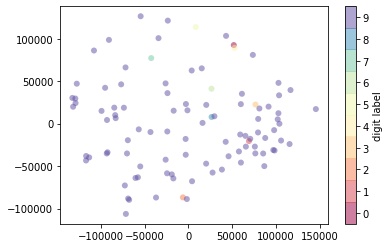

In [ ]:
# plt.scatter(data_projected[:, 0], data_projected[:, 1], c=range(frameCount),
#             edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('Spectral', 10))
# plt.colorbar(label='digit label', ticks=range(10))
# plt.clim(-0.5, 9.5);

Parkinson's Data

In [ ]:
# Load our imports

#Sklearn:
from sklearn.decomposition import PCA;
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix

#Other libs
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
import math;
import seaborn as sns;

In [ ]:
# Load the files from the local drive for the time being.
from google.colab import files

uploaded = files.upload()

#if uploaded['pd_speech_features_datasingleheader.csv']
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

Saving pd_speech_features_datasingleheader.csv to pd_speech_features_datasingleheader.csv


In [ ]:
# Initialize the system and parse the data.
sns.set()
pandasFile = pd.read_csv('pd_speech_features_datasingleheader.csv');

ids = pandasFile['id'].to_numpy();
ids = np.reshape(ids, (ids.shape[0], 1));
originalFullDataFrame = pandasFile.drop('id', axis=1);  # Remove the patient ID.
xDataFrame = originalFullDataFrame.drop('class', axis=1);    # Remove the y value.
yDataFrame = originalFullDataFrame['class'];

columnHeaders = originalFullDataFrame.columns;

#Normalize X data: 
scaler = StandardScaler();
scaler.fit(xDataFrame);
xScaledNumPy = scaler.transform(xDataFrame);
xNumPy = xDataFrame.to_numpy();
yNumPy = yDataFrame.to_numpy();
yNumPy = np.reshape(yNumPy, (yNumPy.shape[0], 1));
originalFullNumPy = np.hstack((ids, xNumPy, yNumPy));

In [ ]:
#shape checks
print(originalFullNumPy.shape);
print(xNumPy.shape)
print(yNumPy.shape)

(756, 755)
(756, 753)
(756, 1)


In [ ]:
# Sort by 'class' (i.e., diseased/healthy).
classSortedNumPy = originalFullNumPy[np.argsort(originalFullNumPy[:, -1])];

# Find where the healthy/diseased boundary is.
splitIndex = -1;
for i in range(classSortedNumPy.shape[0]):
    if (1.0 == classSortedNumPy[i, -1]):
        splitIndex = i;
        break;

# Split into healthy vs. diseased.
healthyUnsortedNumPy = classSortedNumPy[0:splitIndex, :];
diseasedUnsortedNumPy = classSortedNumPy[splitIndex:, :];

healthySortedNumPy = healthyUnsortedNumPy[np.argsort(healthyUnsortedNumPy[:, 0])];  # Sort by ID so that all of a certain ID are grouped together.
healthySortedNumPy = healthySortedNumPy[:, 1:]; # Remove ID column.
healthyFullDataFrame = pd.DataFrame(healthySortedNumPy, columns=columnHeaders); # Create a DataFrame to retain headers.
healthyXDataFrame = healthyFullDataFrame.drop('class', axis=1); # Remove the 'class' column.
#healthyYDataFrame = healthyFullDataFrame.

# Lather, rinse, repeat for diseased.
diseasedSortedNumPy = diseasedUnsortedNumPy[np.argsort(diseasedUnsortedNumPy[:, 0])];
diseasedSortedNumPy = diseasedSortedNumPy[:, 1:];
diseasedFullDataFrame = pd.DataFrame(diseasedSortedNumPy, columns=columnHeaders);
diseasedXDataFrame = diseasedFullDataFrame.drop('class', axis=1);

# Calculate our counts for each sets.
testingRatio = 0.1;
# The strange arithmetic is meant to make sure that all of an individual's samples go together.
healthyTrainingCount = math.floor((healthySortedNumPy.shape[0] / 3) * (1 - testingRatio)) * 3;
diseasedTrainingCount = math.floor((diseasedSortedNumPy.shape[0] / 3) * (1 - testingRatio)) * 3;

# Split apart our sets.
healthyTrainingSetNumPy = healthySortedNumPy[0:healthyTrainingCount, :];
healthyTestingSetNumPy = healthySortedNumPy[healthyTrainingCount:, :];
diseasedTrainingSetNumPy = diseasedSortedNumPy[0:diseasedTrainingCount, :];
diseasedTestingSetNumPy = diseasedSortedNumPy[diseasedTrainingCount:, :];

# Reconstruct our training and testing sets (i.e., (healthy + diseased)x(training vs testing)).
trainingSetNumPy = np.vstack((healthyTrainingSetNumPy, diseasedTrainingSetNumPy));
trainingSetDataFrame = pd.DataFrame(trainingSetNumPy, columns=columnHeaders);
testingSetNumPy = np.vstack((healthyTestingSetNumPy, diseasedTestingSetNumPy));
testingSetDataFrame = pd.DataFrame(testingSetNumPy, columns=columnHeaders);

trainingSetDataNumPy = trainingSetNumPy[:, :-1];
trainingSetLabelsNumPy = trainingSetNumPy[:, -1];

testingSetDataNumPy = testingSetNumPy[:, :-1];
testingSetLabelsNumPy = testingSetNumPy[:, -1];

fullNumPy = np.vstack((trainingSetNumPy, testingSetNumPy));
fullXNumPy = fullNumPy[:, :-1];
fullYNumPy = fullNumPy[:, -1];
fullDataFrame = pd.DataFrame(fullNumPy, columns=columnHeaders);
fullXDataFrame = fullDataFrame.drop('class', axis=1);

In [ ]:
#Shape checks
print(healthySortedNumPy.shape);
print(diseasedSortedNumPy.shape);
print(fullNumPy.shape)

(192, 754)
(564, 754)
(756, 754)


AttributeError: ignored

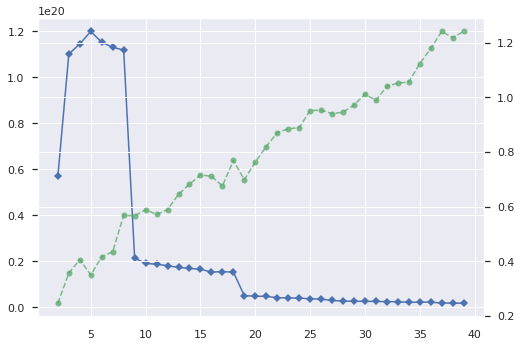

In [ ]:
#Elbow method for Kmeans:
model = KMeans(random_state=0);
visualizer = KElbowVisualizer(model, k=(2,40)); # k=(80,100))
visualizer.fit(xNumPy)        # Fit the data to the visualizer
visualizer.show()     

In [ ]:
clusterCount = 2;
model = KMeans(n_clusters=clusterCount);
model.fit(xNumPy);
kMeans9ClustersLabels = model.labels_;

clusterScores = np.zeros((clusterCount, 2));
for i in range(kMeans9ClustersLabels.shape[0]):
  clusterIndex = kMeans9ClustersLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

102.0, 469.0 = 0.8213660245183888
90.0, 95.0 = 0.5135135135135135


In [ ]:
print(kMeans9Clusters.shape)

In [ ]:
pca170fullModel = PCA(n_components=170);
pca170fullModel.fit(xScaledNumPy); # healthyXDataFrame); # diseasedXDataFrame);
pca170fullXData = pca170fullModel.transform(xScaledNumPy);

In [ ]:
print(np.sum(pca170fullModel.explained_variance_ratio_))

0.9511427490996355


AttributeError: ignored

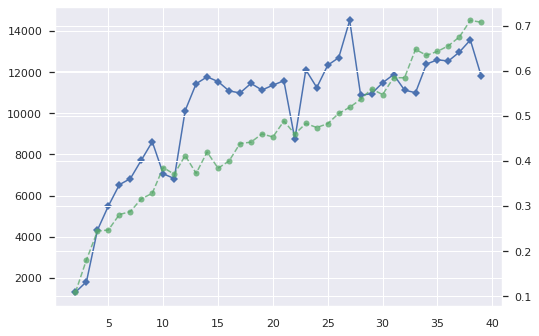

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=0);
visualizer = KElbowVisualizer(model, k=(2,40))

visualizer.fit(pca170fullXData)        # Fit the data to the visualizer
visualizer.show()     

In [ ]:
clusterCount = 6;
model = KMeans(n_clusters=clusterCount);
model.fit(pca170fullXData);
kMeans9ClustersLabels = model.labels_;

clusterScores = np.zeros((clusterCount, 2));
for i in range(kMeans9ClustersLabels.shape[0]):
  clusterIndex = kMeans9ClustersLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

78.0, 42.0 = 0.35
58.0, 159.0 = 0.7327188940092166
10.0, 162.0 = 0.9418604651162791
19.0, 106.0 = 0.848
22.0, 87.0 = 0.7981651376146789
5.0, 8.0 = 0.6153846153846154


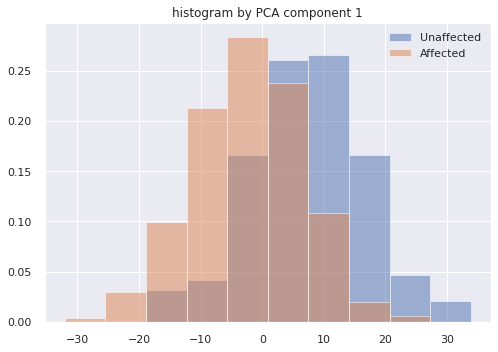

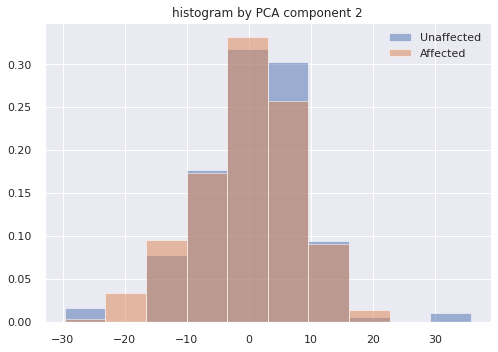

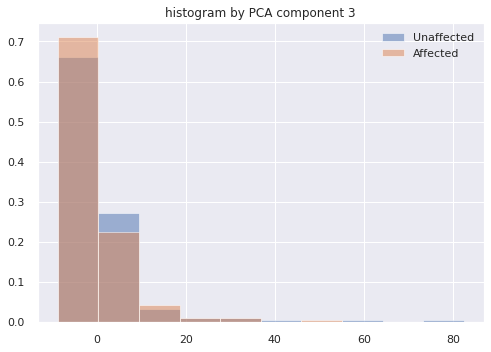

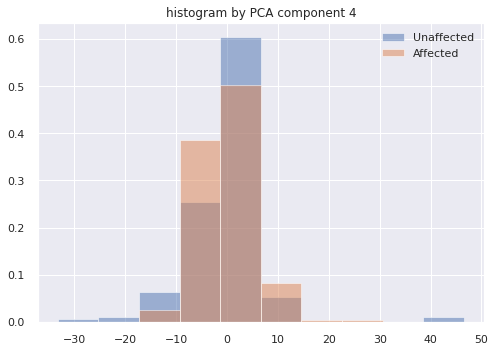

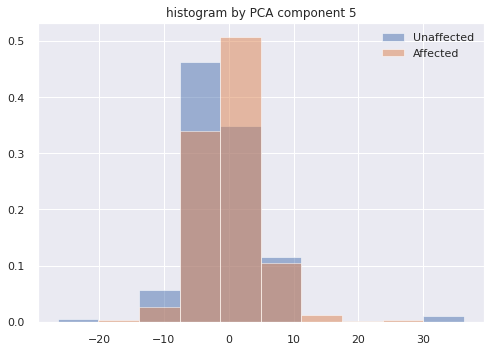

In [ ]:
# HISTOGRAMS OF TOP 5 PCA COMPONENTS:
pcaComponentCount = 5
pca5ModelGraphic = PCA(n_components=pcaComponentCount)
pca5ModelGraphic.fit(fullXDataFrame) #healthyXDataFrame) # diseasedXDataFrame)
graphicPointsHealthy = pca5ModelGraphic.transform(healthyXDataFrame)
graphicPointsDiseased = pca5ModelGraphic.transform(diseasedXDataFrame)
weightsHealthy = np.ones_like(graphicPointsHealthy[:,0])/192
weightsDiseased = np.ones_like(graphicPointsDiseased[:,0])/564

for pca_component in range(pcaComponentCount):
  binCount = 10
  diseasedComponent = graphicPointsDiseased[:, pca_component];
  healthyComponent = graphicPointsHealthy[:, pca_component];
  histComponents = [healthyComponent, diseasedComponent]
  rangeTuple = (min(np.min(diseasedComponent), np.min(healthyComponent)), max(np.max(diseasedComponent), np.max(healthyComponent)))
  #binWidth = math.ceil(max(np.max(diseasedComponent), np.max(healthyComponent)) - min(np.min(diseasedComponent), np.min(healthyComponent)) / width);

  #plt.hist(histComponents, 
  #        alpha=0.5, # the transaparency parameter
  #        label=['Unaffected', 'Affected'],
  #        bins = binCount) #binWidth)

  plt.hist(healthyComponent, 
          alpha=0.5, # the transaparency parameter
          label='Unaffected',
          weights = weightsHealthy,
          range = rangeTuple,
          bins = binCount) #binWidth)
    
  plt.hist(diseasedComponent,
          alpha=0.5,
          label='Affected',
          weights = weightsDiseased,
          range = rangeTuple,
          bins = binCount) # bins(graphicPointsHealthy[:,pca_component],width))
    
  plt.legend(loc='upper right')
  plt.title(f'histogram by PCA component {pca_component+1}')
  plt.show()

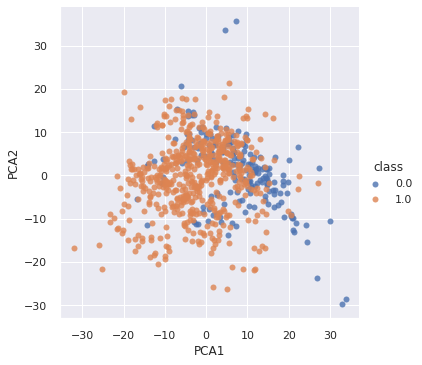

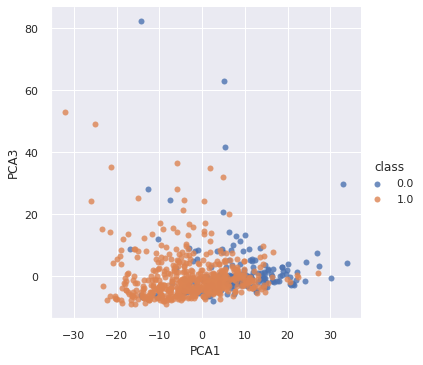

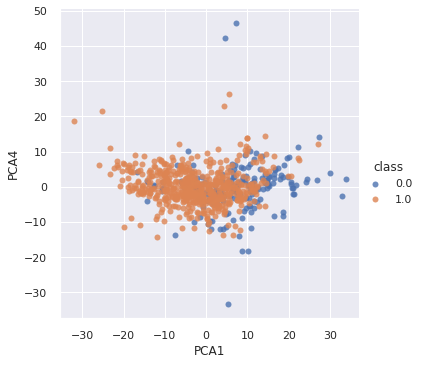

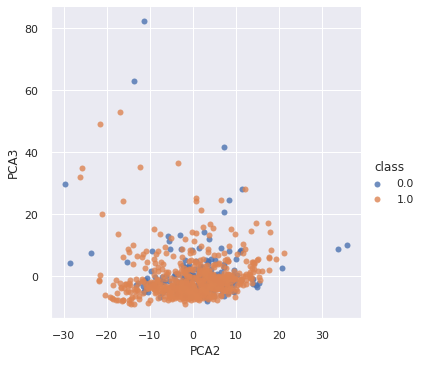

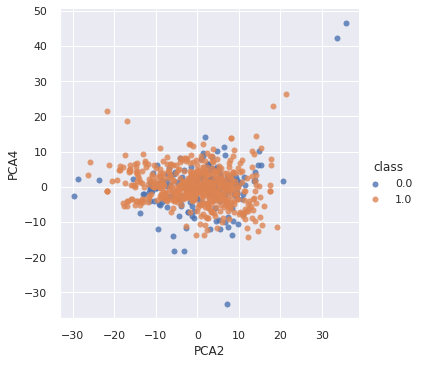

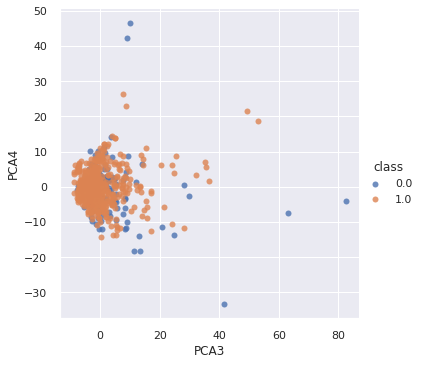

In [ ]:
pcaDiseasedDataSets = np.hstack((graphicPointsDiseased, np.full((graphicPointsDiseased.shape[0], 1), 1)));
pcaHealthyDataSets = np.hstack((graphicPointsHealthy, np.full((graphicPointsHealthy.shape[0], 1), 0)));

pcaDataSetsNumPy = np.vstack((pcaHealthyDataSets, pcaDiseasedDataSets));

biasedTraining = pd.DataFrame(pcaDataSetsNumPy, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'class']);
sns.lmplot(x="PCA1", y="PCA2", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA3", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);

In [ ]:
print(np.sum(pca5ModelGraphic.explained_variance_ratio_))

0.3846116421126373


Try fitting on only healthy individuals

AttributeError: ignored

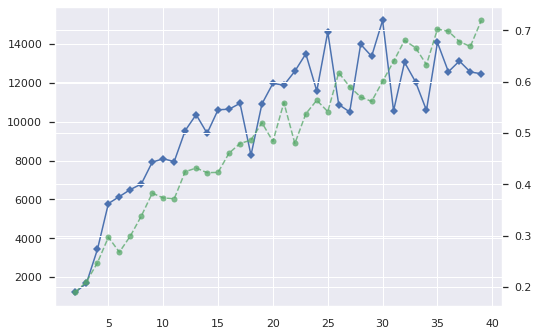

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans();
visualizer = KElbowVisualizer(model, k=(2,40))

visualizer.fit(pca80XData)        # Fit the data to the visualizer
visualizer.show()     

In [ ]:
clusterCount = 10;
model = KMeans(n_clusters=clusterCount);
model.fit(pca80XData);
kMeansPca80ClustersLabels = model.labels_;

clusterScores = np.zeros((clusterCount, 2));
for i in range(kMeansPca80ClustersLabels.shape[0]):
  clusterIndex = kMeansPca80ClustersLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

55.0, 120.0 = 0.6857142857142857
9.0, 30.0 = 0.7692307692307693
33.0, 93.0 = 0.7380952380952381
21.0, 28.0 = 0.5714285714285714
40.0, 176.0 = 0.8148148148148148
6.0, 21.0 = 0.7777777777777778
2.0, 2.0 = 0.5
2.0, 8.0 = 0.8
2.0, 2.0 = 0.5
22.0, 84.0 = 0.7924528301886793


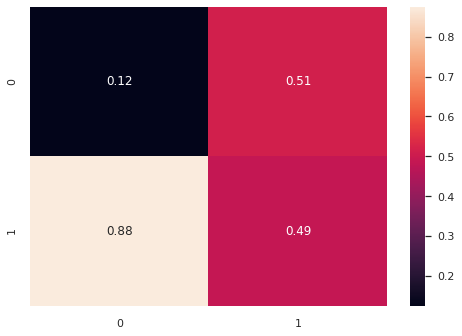

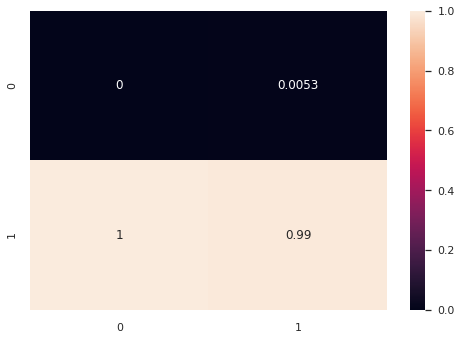

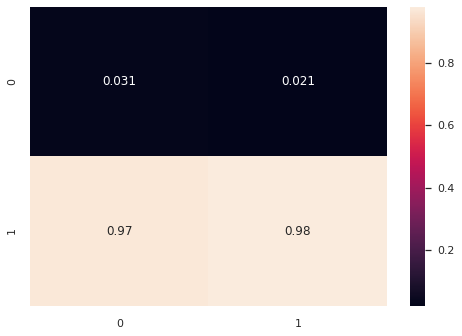

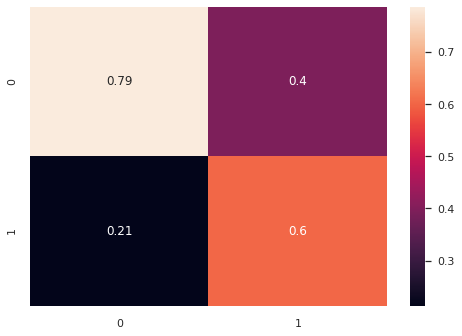

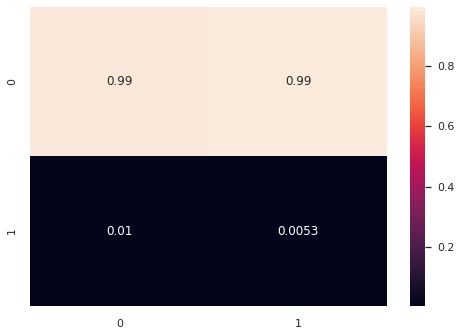

In [ ]:
#GMM confusion matrix heatmap, generated over several different trainings
for i in range(5):
  model = GaussianMixture(n_components=2)
  model.fit(pca170fullXData)
  gmmLabels = model.predict(pca170fullXData)
  cm = confusion_matrix(gmmLabels,yNumPy) / np.asarray([192,564])
  sns.heatmap(cm, annot=True)
  plt.show()

In [ ]:
#print(probs[:25].round(3))
#OLD MANUAL confusion matrix code
clusterScores = np.zeros((clusterCount, 10));
for i in range(gmmClusterLabels.shape[0]):
  clusterIndex = gmmClusterLabels[i];
  healthIndex = yDataFrame[i];
  #print(clusterIndex);
  #print(healthIndex);
  clusterScores[clusterIndex, healthIndex] = np.add(clusterScores[clusterIndex, healthIndex], np.full((1), 1));

for i in range(clusterScores.shape[0]):
  ratio = clusterScores[i, 1] / (clusterScores[i, 0] + clusterScores[i, 1]);
  print(f"{clusterScores[i, 0]}, {clusterScores[i, 1]} = {ratio}");

#plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

#print(gmm9ClustersLabels.shape)
#for i in range(5):
#  print(gmm9ClustersLabels[i]);

85.0, 296.0 = 0.7769028871391076
107.0, 268.0 = 0.7146666666666667


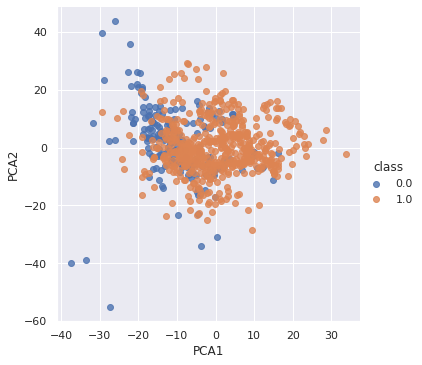

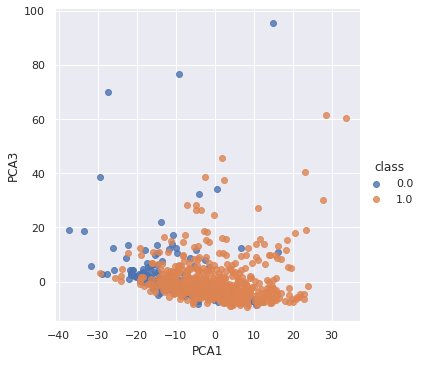

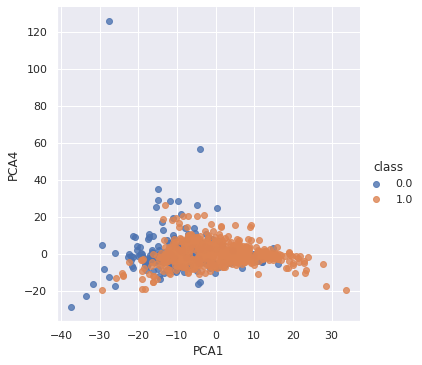

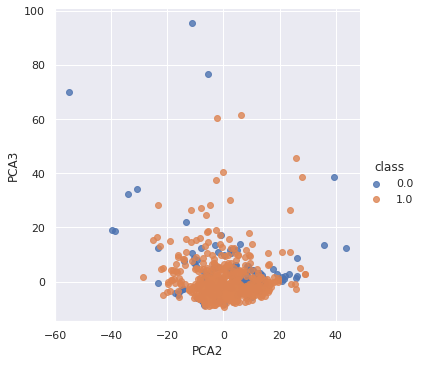

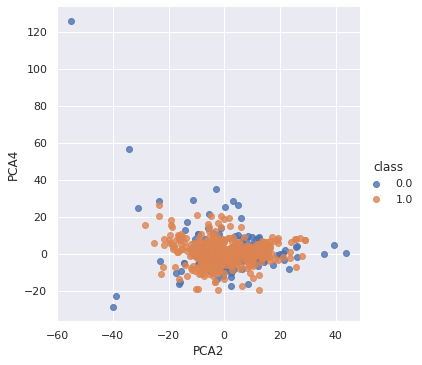

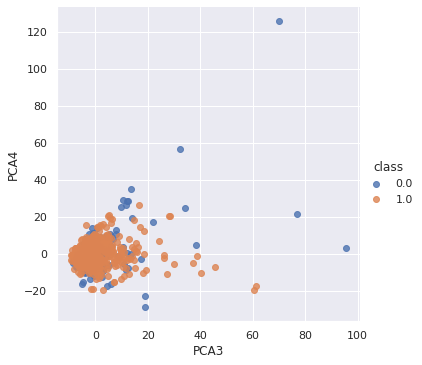

In [ ]:
# 2-component PCA Analysis (only diseased for fitting)
pcaModelDiseased2 = make_pipeline(StandardScaler(),PCA(n_components=4));
pcaModelDiseased2.fit(diseasedXDataFrame); #healthyXDataFrame);
pcaDiseasedDataSets = pcaModelDiseased2.transform(diseasedXDataFrame);
pcaHealthyDataSets = pcaModelDiseased2.transform(healthyXDataFrame);

pcaDiseasedDataSets = np.hstack((pcaDiseasedDataSets, np.full((pcaDiseasedDataSets.shape[0], 1), 1)));
pcaHealthyDataSets = np.hstack((pcaHealthyDataSets, np.full((pcaHealthyDataSets.shape[0], 1), 0)));

pcaDataSetsNumPy = np.vstack((pcaHealthyDataSets, pcaDiseasedDataSets));

biasedTraining = pd.DataFrame(pcaDataSetsNumPy, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'class']);
sns.lmplot(x="PCA1", y="PCA2", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA3", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
sns.lmplot(x="PCA3", y="PCA4", hue='class', data=biasedTraining, fit_reg=False);
#pcaDataSet = pd.DataSet()

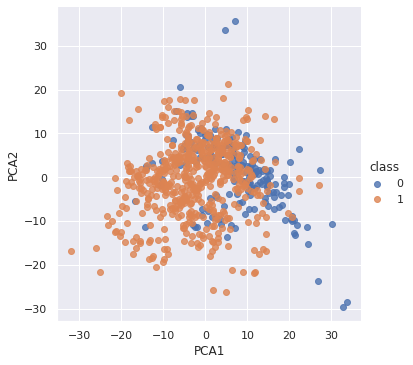

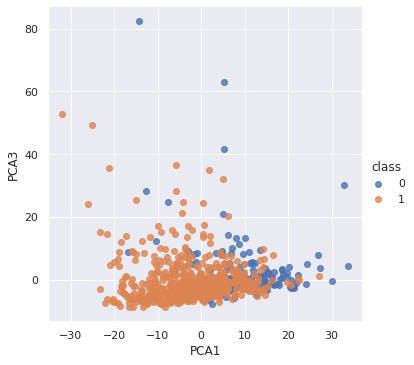

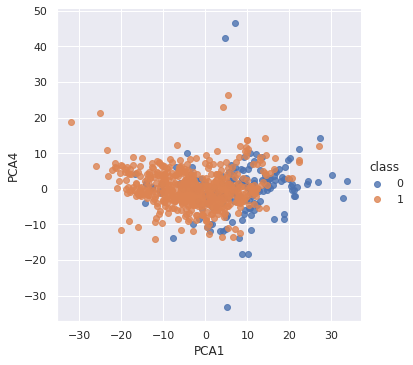

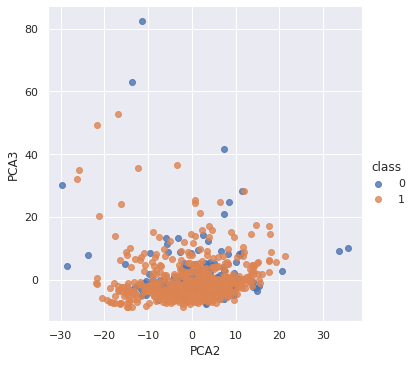

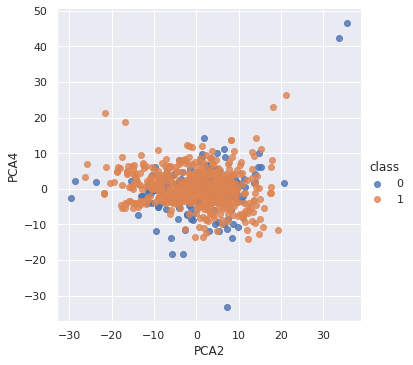

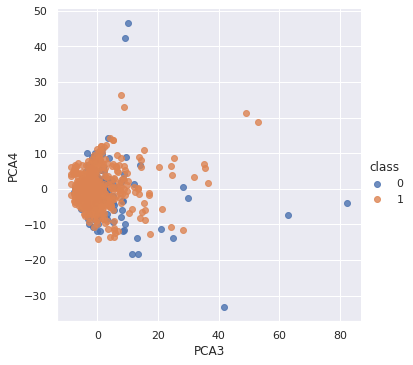

In [ ]:
# 4-component PCA Analysis
pcaModel4 = make_pipeline(StandardScaler(),PCA(n_components=4))            # 2. Instantiate the model with hyperparameters
pcaModel4.fit(xDataFrame)                      # 3. Fit to data. Notice y is not specified!
pcaDataSets = pcaModel4.transform(xDataFrame)         # 4. Transform the data to two dimensions

pandasFile['PCA1'] = pcaDataSets[:, 0]
pandasFile['PCA2'] = pcaDataSets[:, 1]
pandasFile['PCA3'] = pcaDataSets[:, 2]
pandasFile['PCA4'] = pcaDataSets[:, 3]
sns.lmplot(x="PCA1", y="PCA2", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA3", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA1", y="PCA4", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA3", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA2", y="PCA4", hue='class', data=pandasFile, fit_reg=False);
sns.lmplot(x="PCA3", y="PCA4", hue='class', data=pandasFile, fit_reg=False);

# Rats without Hats
### Contributors:
* [Justin Cropsey](https://github.com/jcropsey-gatech)
* [David Gordon](https://github.com/DavidCGordon)
* [Su Timurturkan](https://github.com/sutimurturkan)

## Summary Figure
![Project Infographic](Rats_with_Hats_Project_Poster.jpg)

## Introduction
Due to loss of team members and the complexity of the Allen Brain Observatory's data, we switched to Sohel Rana's [Parkinson's Disease Classification](https://www.kaggle.com/sohelranaccselab/parkinsons-disease-classification) (PDC) dataset on Kaggle.

[Parkinson's Disease](https://www.mayoclinic.org/diseases-conditions/parkinsons-disease/symptoms-causes/syc-20376055) (PD) is a progressive neurodegenerative disorder that is part of the Lewy Body Dementias umbrella that also includes [Dementia with Lewy Bodies](https://www.mayoclinic.org/diseases-conditions/lewy-body-dementia/symptoms-causes/syc-20352025) (DLB). As the name of the umbrella term implies, the defining characteristic of both disorders is the presence of Lewy bodies (plaques in the brain). While both disorders ultimately result in the same symptoms, the distinguisher between them is whether the tremor (PD) or another symptom appears first.

Like other diseases that plaques in the brain (e.g., Alzheimer's disease), biopsy is off limits due to the dangers associated with neurosurgery. While a form of single-photon emission computerized tomography (SPECT) scan called a dopamine-transporter scan (DaTscan) can assist in diagnosis, it is expensive. Our goal is to elaborate a minimally invasive, low-cost solution using speech characteristics and machine learning to aid in diagnosis of PD.

For our project, we will apply the unstructured learning techniques taught in this class to analyze over 750 dimensions of speech characteristics. Afterwards, we will apply structured learning techniques to the annotated datasets to be able to predict whether a patient exhibiting certain patterns of speech characteristics merits further evaluation for PD.

## Methods
The PDC dataset contains 754 different dimensions of data measuring various speech pathologies along with binary gender categorization. Each patient was sampled three times. There are 64 unaffected individuals and 188 affected individuals represented in the data set (756 samples total). No missing data points were observed in the data set. Following import, the data was split apart into various blocks (viz., headers, patient IDs, and X-Y data). The X-Y data (not including the disease classification (Y)) was scaled using Scikit-Learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

    scaler = StandardScaler()
	scaler.fit(xDataFrame)
	xNumPy = scaler.transform(xDataFrame);

The X-Y data set was sorted based on disease classification (Y) and split into unaffected vs affected sets at the boundary. The two sets were subsequently individually split by a common ratio into training vs testing sets, yielding unaffected-training, unaffected-testing, affected-training, and affected-testing set, while ensuring that all samples of a particular patient went into either their respective training or testing set but not both.

A k-means elbow analysis in the range of k = \[4,40\] was performed on the entire data set using Yellowbrick's [K-Elbow Visualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html). Higher orders were examined in narrower ranges due to the increased processing time associated with higher orders.
	model = KMeans();
	visualizer = KElbowVisualizer(model, k=(2,40));

	visualizer.fit(xDataFrame)        # Fit the data to the visualizer
	visualizer.show()

A direct k-means analysis with k = 2 (from the elbow method) was performed on the scaled X data set. The number of representatives in each cluster were tabulated to determine which cluster represented which disease status.

A [Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) was performed with Scikit-Learn's PCA() over the entire X data set. n was chosen to be 170 because that represented 95.1% of the variance observed in the data. Another k-means elbow analysis in the range of k = \[2, 40\] was performed on the PCA transformed data. Again k was chosen to be 2, and a k-means analysis performed.

Under the assumption that PD is a collection of diseases due to heterogeneity in the rates of degeneration across the various neuroanatomical regions in patients, the PCA and subsequent k-means analysis was performed again, but with the PCA only fitted over the unaffected or the affected subsets of X. (Transformation was performed across the entire data set.) The goal was to identify a well-defined cluster of one of the disease states and then define the other states as everything else (i.e., universe - cluster). Due to the high explained-variance ratio when fitting PCA to unaffected data alone, an additional k = 6 k-means analysis was performed.

A 2-component [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (GMM) was iteratively run over the raw data set and the n=170 holistically-fitted PCA data set with [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) rendered with the goal being to identify matrices where one of the diagonals is much larger than the other.

Ten-bin [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) were prepared on a 5-component PCA analysis fitted to the full, unaffected, and affected data sets, respectively.

## Results
Because the data set is unbalanced in the number of affected vs unaffected individuals, a randomly selected sample from the data set has a 74.6% probability of being affected. In the tables presented below, we are searching for methods that have noticeable deviation from probability due to chance alone.

#### Fig. A1 - K-Means elbow analysis over entire scaled data set
![K-Means Elbow Analysis over Raw Data](raw_kmeans_elbow2_40.png)

#### Table B1 - Partitioning of unaffected vs affected into clusters by K-Means over entire scaled data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 39 | 322 | 0.892 |
| 153 | 242 | 0.613 |

#### Fig. A2 - K-Means elbow analysis over 170-component PCA data fit to entire data set
![K-Means Elbow Analysis over PCA-170 Entire Data](pca170_kmeans_elbow2_40.png)

#### Table B2 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to entire data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 38 | 320 | 0.894 |
| 154 | 244 | 0.613 |

#### Fig. A3 - K-Means elbow analysis over 170-component PCA data fit to affected data set
![K-Means Elbow Analysis over PCA-170 Affected Data](pca170_diseased_kmeans_elbow2_40.png)

#### Table B3 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to affected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 156 | 247 | 0.613 |
| 36 | 317 | 0.898 |

#### Fig. A4 - K-Means elbow analysis over 170-component PCA data fit to unaffected data set
![K-Means Elbow Analysis over PCA-170 Unaffected Data](pca170_healthy_kmeans_elbow2_40.png)

When the 170-component PCA was fitted to unaffected data, a 0.9984 explained variance was achieved.

##### Table B4 - Partitioning of unaffected vs affected into clusters by K-Means over 170-component PCA data fit to unaffected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 44 | 337 | 0.885 |
| 148 | 227 | 0.605 |

### K-Means Analysis (with k=6) over 170-component PCA fit to Unaffected Data

#### Table B5 - Partitioning of unaffected vs affected into clusters by K-Means (k=6) over 170-component PCA data fit to unaffected data set
| Unaffected | Affected | Ratio |
|----|----|----|
| 78 | 42 | 0.350 |
| 58 | 159 | 0.733 |
| 10 | 162 | 0.942 |
| 19 | 106 | 0.848 |
| 22 | 87 | 0.798 |
| 5 | 8 | 0.615 |

### Figs. A5 - Two-Component GMM on 170-component PCA fitted to the entire data set
![GMM Confusion Matrix 1](gmm_confusionmatrix_1.png)
![GMM Confusion Matrix 2](gmm_confusionmatrix_2.png)
![GMM Confusion Matrix 3](gmm_confusionmatrix_3.png)
![GMM Confusion Matrix 4](gmm_confusionmatrix_4.png)
![GMM Confusion Matrix 5](gmm_confusionmatrix_5.png)

### Figs. A6 - Five-Component PCA Fitted to Full Data Set
![PCA Component 2 vs. PCA Component 1](full_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](full_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](full_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](full_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](full_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](full_pca5_3_4.png)

### Figs. A7 - Five-Component PCA Fitted to Affected Data Set
![PCA Component 2 vs. PCA Component 1](affected_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](affected_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](affected_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](affected_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](affected_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](affected_pca5_3_4.png)

### Figs. A8 - Five-Component PCA Fitted to Unaffected Data Set
![PCA Component 2 vs. PCA Component 1](unaffected_pca5_1_2.png)
![PCA Component 3 vs. PCA Component 1](unaffected_pca5_1_3.png)
![PCA Component 4 vs. PCA Component 1](unaffected_pca5_1_4.png)
![PCA Component 3 vs. PCA Component 2](unaffected_pca5_2_3.png)
![PCA Component 4 vs. PCA Component 2](unaffected_pca5_2_4.png)
![PCA Component 4 vs. PCA Component 3](unaffected_pca5_3_4.png)

### Figs. A9 - Ten-Bin Histogram of 5-Component PCA Fitted to Full Data Set
![Histogram of PCA Component 1](hist10_full_component1.png)
![Histogram of PCA Component 2](hist10_full_component2.png)
![Histogram of PCA Component 3](hist10_full_component3.png)
![Histogram of PCA Component 4](hist10_full_component4.png)
![Histogram of PCA Component 5](hist10_full_component5.png)

### Figs. A10 - Ten-Bin Histogram of 5-Component PCA Fitted to Affected Data Set
![Histogram of PCA Component 1](hist10_affected_component1.png)
![Histogram of PCA Component 2](hist10_affected_component2.png)
![Histogram of PCA Component 3](hist10_affected_component3.png)
![Histogram of PCA Component 4](hist10_affected_component4.png)
![Histogram of PCA Component 5](hist10_affected_component5.png)

### Figs. A11 - Ten-Bin Histogram of 5-Component PCA Fitted to Unaffected Data Set
![Histogram of PCA Component 1](hist10_unaffected_component1.png)
![Histogram of PCA Component 2](hist10_unaffected_component2.png)
![Histogram of PCA Component 3](hist10_unaffected_component3.png)
![Histogram of PCA Component 4](hist10_unaffected_component4.png)
![Histogram of PCA Component 5](hist10_unaffected_component5.png)

## Discussion
The most obvious problems with our data are the presence of numerous outliers, and the amount of overlap of affected and unaffected individuals. This is most salient from the K-Means "elbow" plots (Figures A1, A2, A3, and A4), which resemble nothing like what an elbow plot should.

As noted in the Results, the data set is biased towards affected individuals by almost 3:1. K-means alone was able to do better than random chance by 17.8% and 19.6% unaffected vs affected respectively.

The 170-component PCA had lackluster performance in improving the categorization of data relative to a simple K-means clustering on scaled data (0.613:0.894 vs 0.613:0.892). Ironically, fitting the 170-component PCA to only the unaffected data improved the amount of explained variance (99.84% vs 95.1%) but had little impact on the categorization (0.605:0.885 vs 0.613:0.892). This evidences the belief that unaffected individuals constitute a "cloud" whereas affected individuals are outliers.

Table B6 with the results of the 6-cluster K-means analysis over the 170-compoent PCA data fitted to the unaffected data set provides a counter argument to this belief with due to its above average clustering of affected individuals. As noted in the Introduction, PD is a collection of diseases depending on which nuclei are affected and their respective severities.

Gaussian Mixture Modeling provided interesting results: The results were non-probabilistic (i.e., most entries were classified into a single cluster). In other words, it reduced itself to K-mean. Figures A5 show the confusion matrix resulting from GMM. While we did see the some of the desired results of one of the diagonals being much stronger than the other, given the nature of implications, none of them reached a level where we would feel confident enough to use them for this problem.

Figures A6, A7, and A8 are scatter plots of the various PCA components against each other. They serve to ellucidate the problem with the data overlapping. (The opacity was not attenuated with these graphs, and thus, the orange conceals some of the blue points.)

Figures A9, A10, and A11 are 10-bin histograms of 170-component PCA data fitted to the entire, affected, and unaffected data sets, respectively. When fit to the full data set, the primary PCA component exhibits the most distinction between the two disease states. However, when fit to a biased disease state, higher-order components do contribute to the distinction.

Fitting the PCA to the affected state produced some interesting results: The primary component showed more spread compared to the unaffected group, evidencing that PD is a collection of diseases. The secondary component showed a rightward shift in the affected group. The higher-order components do show additional differences, but not as significant as the lower-order components.

Fitting the PCA to the unaffected state also produced some interesting results: There are distinct shifts in the affected group relative to the unaffected group. Components 1 and 5 show a concentrating effect, which is to be expected with a neuromuscular disease like PD and its loss of fluidity of movement.

DBSCAN was also performed on the data but failed to produce anything more than random and thus is not included in the Results.

## References
[Prediction of Parkinson's disease using speech signal with Extreme Learning Machine](https://ieeexplore.ieee.org/abstract/document/7755419?casa_token=1aO88moUx48AAAAA:ub2CWrt38kw_ULeQK_zidk_ZMNRbEiTi9nNxtUOa3BNBoEbGqBD4UvQZ3cha4Od7-JtjG-i6)

[Parkinson’s Disease Diagnosis in Cepstral Domain Using MFCC
and Dimensionality Reduction with SVM Classifier](https://www.hindawi.com/journals/misy/2021/8822069/)

[LSTM Siamese Network for Parkinson’s Disease Detection
from Speech](https://ieeexplore.ieee.org/abstract/document/8969430?casa_token=IgSUTOkHeJoAAAAA:7DZe463IBhOllBG6uAAlPxUdaIbt9q0qRaykNNijhjD-xXcyW3Ks4WBwwozB8DnbAiL2IZA9)

[Collection and Analysis of a Parkinson Speech Dataset With Multiple Types of Sound Recordings](https://www.researchgate.net/publication/260662600_Collection_and_Analysis_of_a_Parkinson_Speech_Dataset_With_Multiple_Types_of_Sound_Recordings)


In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# Fit to data and predict using pipelined scaling, GNB and PCA.
scaled_model = make_pipeline(StandardScaler(), PCA(n_components=2), GaussianNB())
scaled_model.fit(X_train, y_train)
pred_test_std = std_clf.predict(X_test)

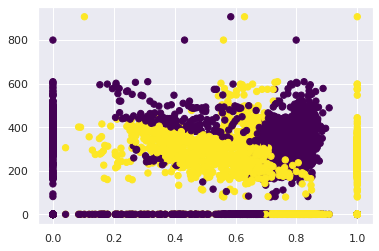

In [ ]:
from sklearn import mixture

i = 0;
j = 1;
X = bothDataSetsNumPy[:, (i, j)];
gmm = make_pipeline(StandardScaler(),mixture.GaussianMixture(n_components=2, covariance_type='full')).fit(X);
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
#for i in range(5):
#  for j in range(i + 1, 5):


In [ ]:
print(bothDataSetsNumPy.shape)

(756, 754)


Clustered: 120 healthy vs. 368 diseased
Noise: 72 healthy vs. 196 diseased
Estimated number of clusters: 1
Estimated number of noise points: 268
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.003


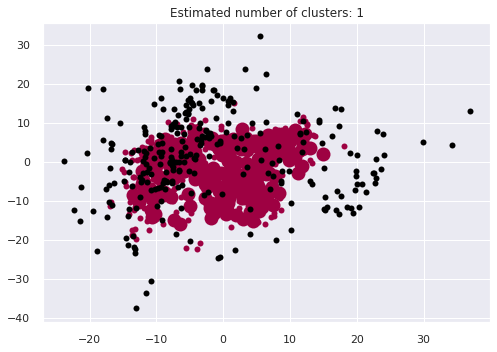

In [ ]:
#DBSCAN Trials
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=20, min_samples=50).fit(pca80XData); # fullXNumPy)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labelSet = set(labels);

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(labelSet) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

clusteredDiseased = 0;
clusteredHealthy = 0;
noiseDiseased = 0;
noiseHealthy = 0;
for i in range(labels.shape[0]):
  if 0 == yNumPy[i]:
    if -1 == labels[i]:
      noiseHealthy = noiseHealthy + 1;
    else:
      clusteredHealthy = clusteredHealthy + 1;
  else:
    if -1 == labels[i]:
      noiseDiseased = noiseDiseased + 1;
    else:
      clusteredDiseased = clusteredDiseased + 1;

print(f'Clustered: {clusteredHealthy} healthy vs. {clusteredDiseased} diseased');
print(f'Noise: {noiseHealthy} healthy vs. {noiseDiseased} diseased');

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(fullYNumPy, labels))
print("Completeness: %0.3f" % metrics.completeness_score(fullYNumPy, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(fullYNumPy, labels))
print("Adjusted Rand Index: %0.3f" \
      % metrics.adjusted_rand_score(fullYNumPy, labels))
#print("Adjusted Mutual Information: %0.3f" \
#      % metrics.adjusted_mutual_info_score(fullYNumPy, labels))
#print("Silhouette Coefficient: %0.3f" \
#      % metrics.silhouette_score(fullXNumPy, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = pca80XData[class_member_mask & core_samples_mask]
    if (0 != xy.shape[0]):
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=14)

    xy = pca80XData[class_member_mask & ~core_samples_mask]
    if (0 != xy.shape[0]):
      plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
              markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()